In [1]:
import json 

dictionary = [{'n': 8,
              'x': [-6, 1, 3, 6, 8, 10, 11, 12],
              'y': [-2, 2, 3.5, 3.5, 2.8, -4, 2.8, 5],
              'p': [0, 0, 1, 3.6, 0, 0, 0],
              'step' : 0.1},
              {'n': 12,
               'x': [-11, -10, -9, -6, -5, -2.5, 0, 5, 8, 9, 10, 11],
               'y': [0, 1.4, 1.6, 1.7, 2, 4, 4, 4, 2, 1.7, 1.4, 0],
               'p': [8.4, 8.4, 3.4, 0, 0, 5.6, 2.8, 0, 8, 7.6, 7.6]
               ,'step': 0.1},
             {'n': 5,
              'x': [-5, -2, -0.5, 3, 8],
              'y': [2, 4, -1, 5, 1],
              'p': [0, 1, 1, 0],
              'step': 0.01},
             {'n': 7,
              'x': [0, 1, 1.2, 2.5, 3.8, 4, 5],
              'y': [-2, 0, 5, 0, 5, 0, -2],
              'p': [0, 5, 25, 25, 25, 25],
              'step': 0.01},
             {'n': 5,
              'x': [-2, -1, 0, 1, 2],
              'y': [0.13534, 0.36788, 1.0, 2.7183, 7.3891],
              'p': None,
              'step': 0.01}
             ]
import json
with open('tests.json', 'w') as fp:
    json.dump(dictionary, fp)

n: 8
x: [-6, 1, 3, 6, 8, 10, 11, 12]
y: [-2, 2, 3.5, 3.5, 2.8, -4, 2.8, 5]
p: [0, 0, 1, 3.6, 0, 0, 0]
step: 0.1
Saved in plot0.png successfully


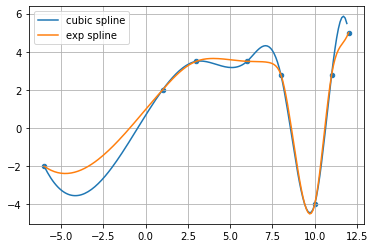


n: 12
x: [-11, -10, -9, -6, -5, -2.5, 0, 5, 8, 9, 10, 11]
y: [0, 1.4, 1.6, 1.7, 2, 4, 4, 4, 2, 1.7, 1.4, 0]
p: [8.4, 8.4, 3.4, 0, 0, 5.6, 2.8, 0, 8, 7.6, 7.6]
step: 0.1
Saved in plot1.png successfully


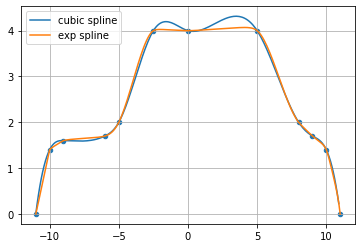


n: 5
x: [-5, -2, -0.5, 3, 8]
y: [2, 4, -1, 5, 1]
p: [0, 1, 1, 0]
step: 0.01
Saved in plot2.png successfully


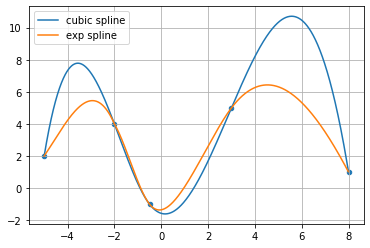


n: 7
x: [0, 1, 1.2, 2.5, 3.8, 4, 5]
y: [-2, 0, 5, 0, 5, 0, -2]
p: [0, 5, 25, 25, 25, 25]
step: 0.01
Saved in plot3.png successfully


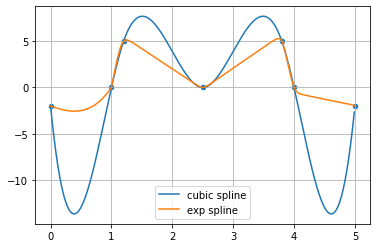


n: 5
x: [-2, -1, 0, 1, 2]
y: [0.13534, 0.36788, 1.0, 2.7183, 7.3891]
p: None
step: 0.01
Saved in plot4.png successfully


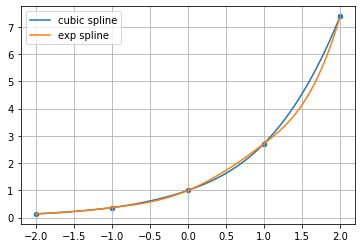


Examples of various tension
Saved in plot_tension.png successfully


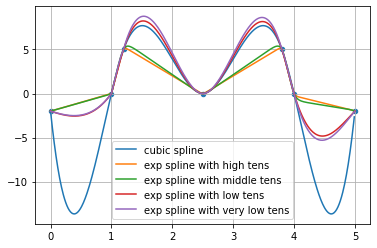

Saved in runge_func.png successfully


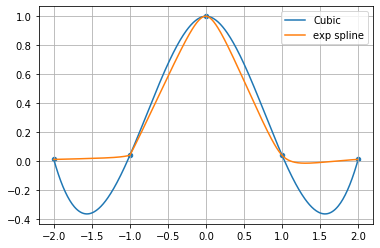

In [2]:
import math
import numpy as np
import json
import argparse
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


class CoeffsException(Exception):
    pass

class SplineException(Exception):
    pass

def expCoeff(n, x, y, p):
    """Computation exponential spline coefficients"""
    # Out coefficients
    d = [0.0] * (n + 1)
    dq = [0.0] * n
    h = [0.0] * n
    hp = [0.0] * n
    ph = [0.0] * n

    # Computation elements of the tridiagonal system
    index, n_less = 0, n - 1
    c, c1, c2, u, v, w = 0.0, 0.0, 0.0, y[0], 0.0, 0.0

    if n < 3:
        raise CoeffsException(f'The value n must be >= 3, from function \"expCoeff\"')

    q = [0.0] * (n + 1)
    r = [0.0] * (n + 1)
    for i in range(1, n):
        index = i - 1
        h[index] = x[i] - x[index]

        if h[index] < 0.0:
            raise CoeffsException(f'The value h[i] = {h[index]} must be >= 0, from function \"expCoeff\"')

        v = y[i]
        hp[index] = abs(h[index] * p[index])

        if h[index] == 0.0:
            d[i] = v
        else:
            d[i] = (v - u) / h[index]
            u = v

        if hp[index] > 0.5:
            ph[index] = math.exp(-hp[index])
            c = ph[index] ** 2
            c1 = 1.0 - c
            c2 = c1 / hp[index]
            c1 *= hp[index] / h[index]
            q[i] = (1.0 - c2 + c) / c1
            r[i] = (c2 - 2.0 * ph[index]) / c1
        else:
            # using auxiliary function sinh
            c = hp[index] * hp[index]
            ph[index] = sinh(c)
            w = h[index] / (1.0 + c * ph[index])
            c *= 0.25
            c2 = 1.0 + c * sinh(c)
            q[i] = (0.5 * c2 ** 2 - ph[index]) * w
            r[i] = ph[index] * w

    """
       solution of the tridiagonal system with
       diagonal:        q[i] + q[i+1] i = 1,  n_less
       off-diagonal:    r[i]          i = 2,  n_less
       right hand side: d[i+1] - d[i] i = 1,  n_less
       second difference coefficient: dq[i] = d[i+1] - d[i] i = 1, n_less
    """

    d[0] = 0.0
    u = 0.0
    for i in range(n_less):
        q[i] = q[i] + q[i + 1] - u * r[i]
        dq[i] = d[i + 1] - d[i]
        d[i] = dq[i] - u * d[i - 1]
        u = r[i + 1] / q[i]
    d[n] = 0.0
    for i in range(n_less, 1, -1):
        d[i] = (d[i] - r[i + 1] * d[i + 1]) / q[i]

    return d, dq, h, hp, ph


def expSpline(n, x, y, p, d, h, hp, ph, oX, i):
    """Building exponential spline"""

    if i > n - 1:
        raise SplineException(f'Wrong parameters, from function \"expSpline\"')

    index = i + 1
    t = (oX - x[i]) / h[i]
    t_1 = 1.0 - t

    if t > 1.0 or t < 0.0:
        raise SplineException(f'Wrong parameters, from function \"expSpline\"')

    if hp[i] > 0.5:
        e = math.exp(-t * hp[i])
        e_1 = math.exp(-t_1 * hp[i])
        c = 1.0 - ph[i] ** 2
        exp = y[index] * t + y[i] * t_1 + (d[index] * (e_1 * (1.0 - e ** 2) / c - t) +
                                           d[i] * (e * (1.0 - e_1 ** 2) / c - t_1)) / (p[i] ** 2)
    else:
        e = t * hp[i]
        e_1 = t_1 * hp[i]
        c = h[i] ** 2 / (1.0 + hp[i] ** 2 * ph[i])
        exp = t * (y[index] + d[index] * c * (t ** 2 * sinh(e ** 2) - ph[i])) + \
              t_1 * (y[i] + d[i] * c * (t_1 ** 2 * sinh(e_1 ** 2) - ph[i]))
    return exp


def sinh(a):
    """auxiliary function with best approximation for sinh"""
    return ((0.27713991169e1 - 5 * a + 0.19840927713e1 - 3) * a +
            0.83333336379e1 - 2) * a + 0.16666666666


def get_spline(x, y, n, step, p=None):
    if not p:
        p = [0.0] * (n - 1)
    d, dq, h, hp, ph = expCoeff(n, x, y, p)
    X = []
    Y = []
    for i, point in enumerate(x[:-1]):
        X.append(x[i])
        Y.append(y[i])
        for ox in np.arange(point + step, x[i + 1], step):
            X.append(ox)
            ex = expSpline(n, x, y, p, d, h, hp, ph, ox, i)
            Y.append(ex)
    return X, Y


def draw(x, y, dot_x, dot_y, labels, save_file="plot.png"):
    fig, ax = plt.subplots()

    for i in range(len(x)):
        ax.plot(x[i], y[i], label=f"{labels[i]}")

    ax.scatter(dot_x, dot_y, s=20)
    ax.legend(loc='best')
    ax.grid()
    if save_file:
        fig.savefig(save_file)
        print(f"Saved in {save_file} successfully")
        plt.show()
        plt.close(fig)


def readData(filename, need_args):
    with open(filename, 'r') as json_data:

        data = json.load(json_data)
        output = []
        for item in data:
            dict_ = {}
            for arg in need_args:
                if arg not in item:
                    raise ValueError('No "{0}" in given data'.format(arg))

                dict_[arg] = item[arg]
            output.append(dict_)

    return output


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    need_args = ('n', 'x', 'y', 'p', 'step')
    init_tests = readData('tests.json', need_args)

    for idx, test in enumerate(init_tests):
        for k, v in test.items():
            print(f'{k}: {v}')

        X, Y, labels = [], [], []
        cs = CubicSpline(np.array(test['x']), np.array(test['y']))
        xs = np.arange(test['x'][0], test['x'][-1], test['step'])

        x, y = get_spline(test['x'], test['y'], test['n'], test['step'], test['p'])

        X.append(xs)
        Y.append(cs(xs))
        labels.append('cubic spline')

        X.append(x)
        Y.append(y)
        labels.append('exp spline')

        draw(X, Y, test['x'], test['y'], labels, f'plot{idx}.png')
        print()

    print("Examples of various tension")
    tens_test = init_tests[3]

    X_, Y_, = [], []
    cs = CubicSpline(np.array(tens_test['x']), np.array(tens_test['y']))
    xs = np.arange(tens_test['x'][0], tens_test['x'][-1], tens_test['step'])

    p1 = [50, 50, 50, 50, 50, 50]
    p2 = [20, 20, 20, 20, 20, 20]
    p3 = [0, 0, 0, 0, 0, 0]
    p4 = [0.6, 0.6, 0.6, 0.6, 0.6, 0.6]
    x1, y1 = get_spline(tens_test['x'], tens_test['y'], tens_test['n'], tens_test['step'], p1)
    x2, y2 = get_spline(tens_test['x'], tens_test['y'], tens_test['n'], tens_test['step'], p2)
    x3, y3 = get_spline(tens_test['x'], tens_test['y'], tens_test['n'], tens_test['step'], p3)
    x4, y4 = get_spline(tens_test['x'], tens_test['y'], tens_test['n'], tens_test['step'], p4)

    tens_labels = []
    X_.append(xs)
    Y_.append(cs(xs))
    tens_labels.append('cubic spline')

    X_.append(x1)
    Y_.append(y1)
    tens_labels.append('exp spline with high tens')

    X_.append(x2)
    Y_.append(y2)
    tens_labels.append('exp spline with middle tens')

    X_.append(x3)
    Y_.append(y3)
    tens_labels.append('exp spline with low tens')

    X_.append(x4)
    Y_.append(y4)
    tens_labels.append('exp spline with very low tens')

    draw(X_, Y_, tens_test['x'], tens_test['y'], tens_labels, f'plot_tension.png')

    def runge(x):
        return [1 / (1 + 25 * x_i ** 2) for x_i in x]

    x_runge = [-2, -1, 0, 1, 2]
    y_runge = runge(x_runge)
    cs = CubicSpline(np.array(x_runge), np.array(y_runge))
    xs = np.arange(x_runge[0], x_runge[-1], 0.01)
    labels_runge = []

    X_ = []
    Y_ = []

    X_.append(xs)
    Y_.append(cs(xs))
    labels_runge.append('Cubic')

    x_new, y_new = get_spline(x_runge, y_runge, 5, 0.01, [8, 8, 8, 8])

    X_.append(x_new)
    Y_.append(y_new)
    labels_runge.append('exp spline')

    draw(X_, Y_, x_runge, y_runge, labels_runge, f'runge_func.png')
